<a href="https://colab.research.google.com/github/guilhermegranchopro/Eco-AI.ly/blob/main/Power_Breakdown/Power_Consumption_Breakdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone

In [12]:
# Realiza a requisição à API
response = requests.get(
    "https://api.electricitymap.org/v3/power-breakdown/history?zone=PT",
    headers={"auth-token": "czG7nq1wv9OHi1phrXUn"}
)
data = response.json()

In [13]:
# Obtém o histórico de dados
historico = data.get("history", [])

# Lista de fontes conforme o JSON (para consumo, são as mesmas chaves)
fontes = [
    "nuclear", "geothermal", "biomass", "coal", "wind", "solar",
    "hydro", "gas", "oil", "unknown", "hydro discharge", "battery discharge"
]

In [14]:
def aggregate_consumption(history, time_hours, now):
    """
    Agrega os valores da chave 'powerConsumptionBreakdown' para os registros
    que se encontram no intervalo de 'time_hours' até 'now'.
    Retorna um dicionário com os valores totais e o timestamp limite.
    """
    limite = now - timedelta(hours=time_hours)
    consumption_total = {fonte: 0 for fonte in fontes}

    for registro in history:
        dt_str = registro.get("datetime")
        if not dt_str:
            continue
        # Converte o timestamp para um datetime aware (UTC)
        dt = datetime.fromisoformat(dt_str.replace("Z", "+00:00"))
        if dt < limite or dt > now:
            continue

        consumption = registro.get("powerConsumptionBreakdown", {})
        for fonte in fontes:
            valor = consumption.get(fonte)
            if valor is None:
                valor = 0
            consumption_total[fonte] += valor
    return consumption_total, limite

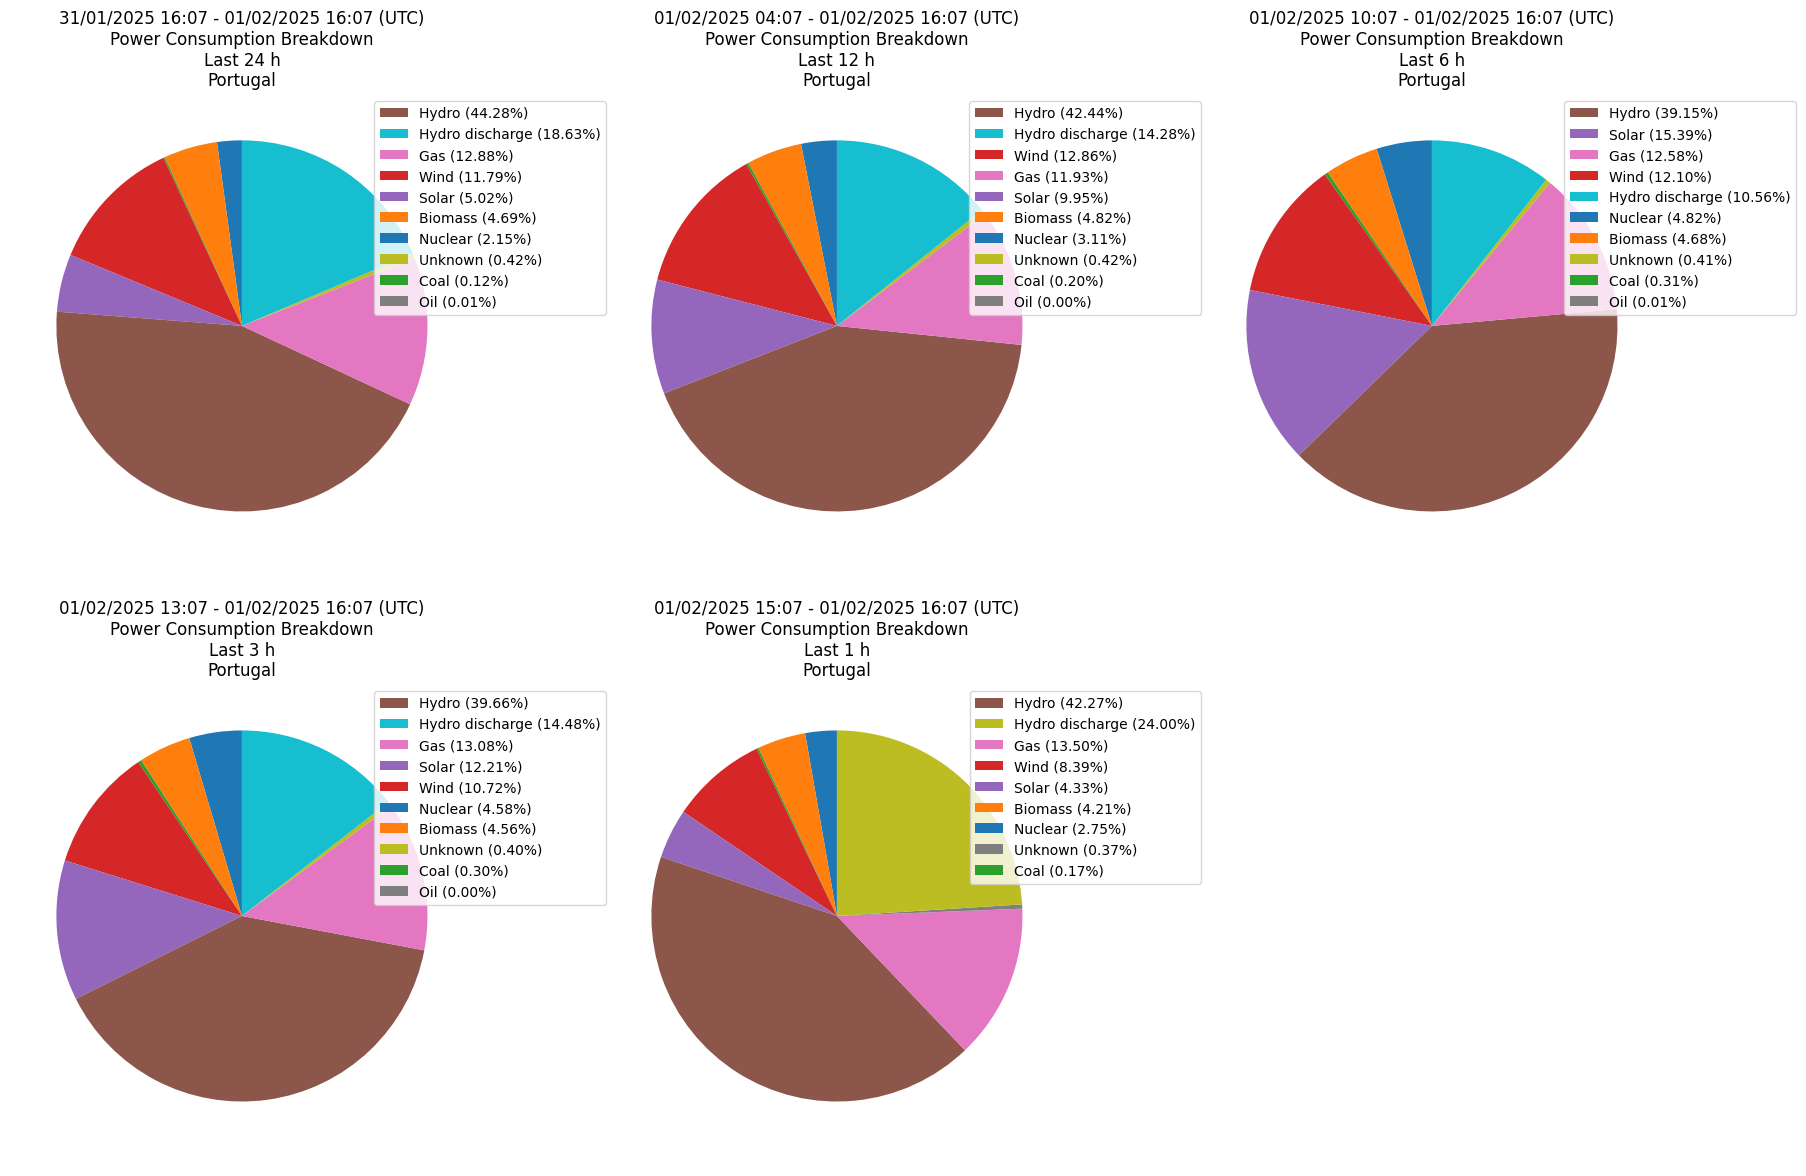

In [15]:
# Define os intervalos desejados (em horas)
time_frames = [24, 12, 6, 3, 1]
now = datetime.now(timezone.utc)

# Cria uma figura com subplots: 2 linhas x 3 colunas (total de 6 subplots, usaremos 5)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, horas in enumerate(time_frames):
    consumption_total, limite = aggregate_consumption(historico, horas, now)

    # Prepara os dados para o gráfico: garante que os valores sejam não negativos
    labels = []
    valores = []
    for fonte, total in consumption_total.items():
        total = max(total, 0)
        if total != 0:
            labels.append(fonte.capitalize())
            valores.append(total)

    # String do time frame para o título do gráfico
    timeframe_str = f"{limite.strftime('%d/%m/%Y %H:%M')} - {now.strftime('%d/%m/%Y %H:%M')} (UTC)"

    if valores:
        soma_total = sum(valores)
        # Cria o gráfico de pizza sem rótulos internos
        wedges, _ = axes[i].pie(valores, startangle=90)

        # Combina labels, valores e wedges em uma lista de tuplas
        items = list(zip(labels, valores, wedges))
        # Ordena os itens de forma decrescente pelo valor (percentual)
        items_sorted = sorted(items, key=lambda x: x[1], reverse=True)
        # Cria os labels para a legenda com os percentuais com 2 casas decimais
        labels_sorted = [
            f"{lab} ({(val/soma_total*100):.2f}%)" for lab, val, _ in items_sorted
        ]
        # Extrai os wedges na ordem ordenada
        wedges_sorted = [w for _, _, w in items_sorted]

        axes[i].set_title(f"{timeframe_str}\nPower Consumption Breakdown\nLast {horas} h\nPortugal")
        axes[i].legend(wedges_sorted, labels_sorted,
                       loc="upper right", bbox_to_anchor=(1.3, 1))
    else:
        axes[i].text(0.5, 0.5, f"Sem dados para as últimas {horas} horas",
                     horizontalalignment='center', verticalalignment='center')
        axes[i].set_title(f"Power Consumption Breakdown\nÚltimas {horas} horas")

# Desativa o subplot extra, se houver
if len(axes) > len(time_frames):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()